In [19]:
# 📥 CSV-Datei laden und vorbereiten

import os
import pandas as pd

# Pfad zur Datei ermitteln
projekt_root = os.path.abspath("../")
dateipfad = os.path.join(projekt_root, "data", "raw", "sickness_table.csv")

# CSV einlesen (Indexspalte = 0)
df = pd.read_csv(dateipfad, index_col=0)

# Datum konvertieren und als Index setzen
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d")
df.set_index("date", inplace=True)

# Tägliche Frequenz erzwingen
df = df.asfreq("D")

# Zielvariable 'y' berechnen (Summe aus sby_need und dafted)
df["y"] = df["sby_need"] + df["dafted"]

# Überblick über den vorbereiteten DataFrame
print("🔍 Vorschau:")
display(df.head())
print("\nℹ️ DataFrame-Info:")
print(df.info())

🔍 Vorschau:


,n_sick,calls,n_duty,n_sby,sby_need,dafted,y
date,,,,,,,
2016-04-01,73,8154.0,1700,90,4.0,0.0,4.0
2016-04-02,64,8526.0,1700,90,70.0,0.0,70.0
2016-04-03,68,8088.0,1700,90,0.0,0.0,0.0
2016-04-04,71,7044.0,1700,90,0.0,0.0,0.0
2016-04-05,63,7236.0,1700,90,0.0,0.0,0.0



ℹ️ DataFrame-Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1152 entries, 2016-04-01 to 2019-05-27
Freq: D
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   n_sick    1152 non-null   int64  
 1   calls     1152 non-null   float64
 2   n_duty    1152 non-null   int64  
 3   n_sby     1152 non-null   int64  
 4   sby_need  1152 non-null   float64
 5   dafted    1152 non-null   float64
 6   y         1152 non-null   float64
dtypes: float64(4), int64(3)
memory usage: 72.0 KB
None


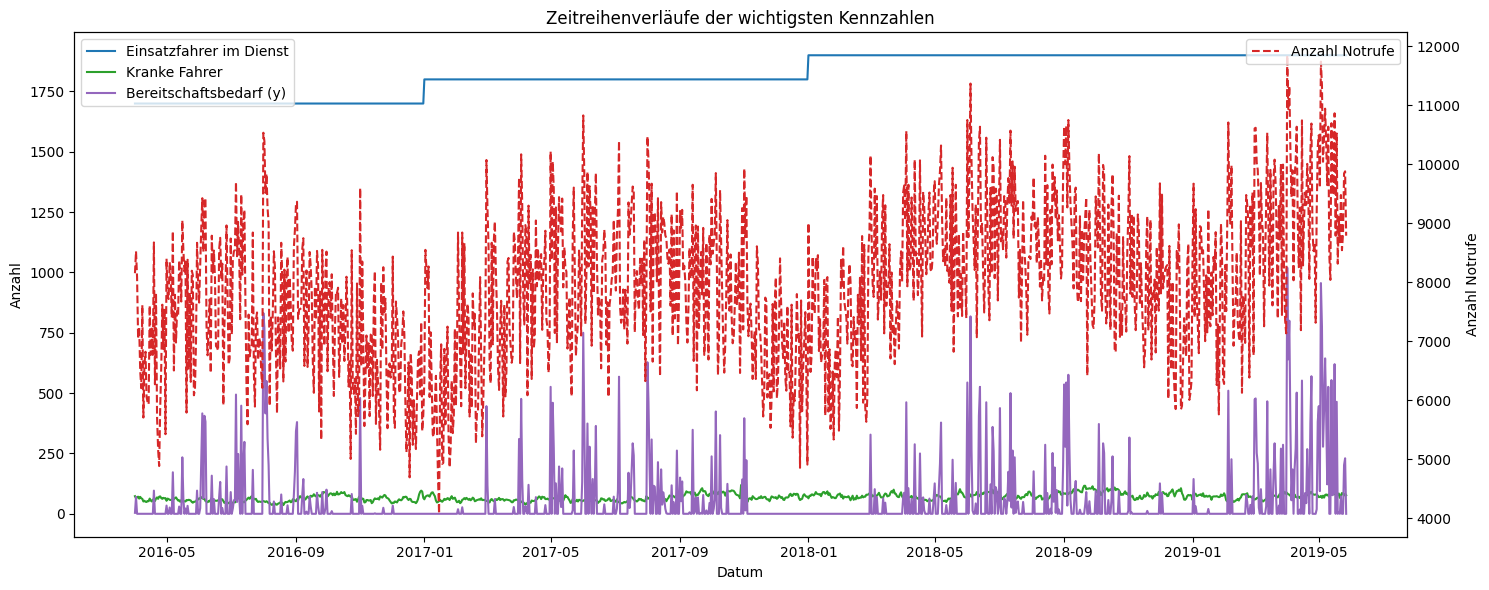

In [20]:
# 📊 Übersichtsgrafik wichtiger Kennzahlen mit zwei y-Achsen

import matplotlib.pyplot as plt

# Prüfen, ob DataFrame geladen ist
if df is None:
    raise ValueError("❌ DataFrame nicht geladen. Bitte vorher die Daten vorbereiten.")

# Grafik erstellen
fig, ax1 = plt.subplots(figsize=(15, 6))

ax1.plot(df.index, df["n_duty"], label="Einsatzfahrer im Dienst", color="tab:blue")
ax1.plot(df.index, df["n_sick"], label="Kranke Fahrer", color="tab:green")
ax1.plot(df.index, df["y"], label="Bereitschaftsbedarf (y)", color="tab:purple")
ax1.set_xlabel("Datum")
ax1.set_ylabel("Anzahl")
ax1.set_title("Zeitreihenverläufe der wichtigsten Kennzahlen")
ax1.legend(loc="upper left")

# Zweite Y-Achse für Notrufe
ax2 = ax1.twinx()
ax2.plot(df.index, df["calls"], label="Anzahl Notrufe", color="tab:red", linestyle="dashed")
ax2.set_ylabel("Anzahl Notrufe")
ax2.legend(loc="upper right")

# Layout & Anzeige
fig.tight_layout()
plt.show()

# Grafikpfad definieren
fig_dir = os.path.join(projekt_root, "reports", "figures", "eda")

# Verzeichnis anlegen, falls nicht vorhanden
os.makedirs(os.path.dirname(fig_dir), exist_ok=True)

# Grafik speichern
path = os.path.join(fig_dir, "zeitreihen_uebersicht.png")
fig.savefig(path, dpi=300)

In [21]:
# 📊 Deskriptive Analyse & Shapiro-Wilk-Test der Spalte 'y'

import seaborn as sns
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import shapiro

# Spalte definieren
spalte = "y"
bins = 30

# Sicherstellen, dass die Spalte existiert
if spalte not in df.columns:
    raise ValueError(f"❌ Spalte '{spalte}' existiert nicht im DataFrame.")

series = df[spalte].dropna()

# Deskriptive Statistiken berechnen
mean_val = series.mean()
median_val = series.median()
std_val = series.std()
skew_val = series.skew()
kurtosis_val = series.kurtosis()

print("📊 Deskriptive Statistiken:")
print(f"  Mittelwert         : {mean_val:.2f}")
print(f"  Median             : {median_val:.2f}")
print(f"  Standardabweichung : {std_val:.2f}")
print(f"  Schiefe            : {skew_val:.2f}")
print(f"  Kurtosis           : {kurtosis_val:.2f}")

# Shapiro-Wilk-Test auf Normalverteilung
shapiro_stat, shapiro_p = shapiro(series)
print("\n🧪 Shapiro-Wilk-Test:")
print(f"  Teststatistik = {shapiro_stat:.3f}")
print(f"  p-Wert        = {shapiro_p:.3f}")

📊 Deskriptive Statistiken:
  Mittelwert         : 51.05
  Median             : 0.00
  Standardabweichung : 131.32
  Schiefe            : 3.42
  Kurtosis           : 13.19

🧪 Shapiro-Wilk-Test:
  Teststatistik = 0.455
  p-Wert        = 0.000


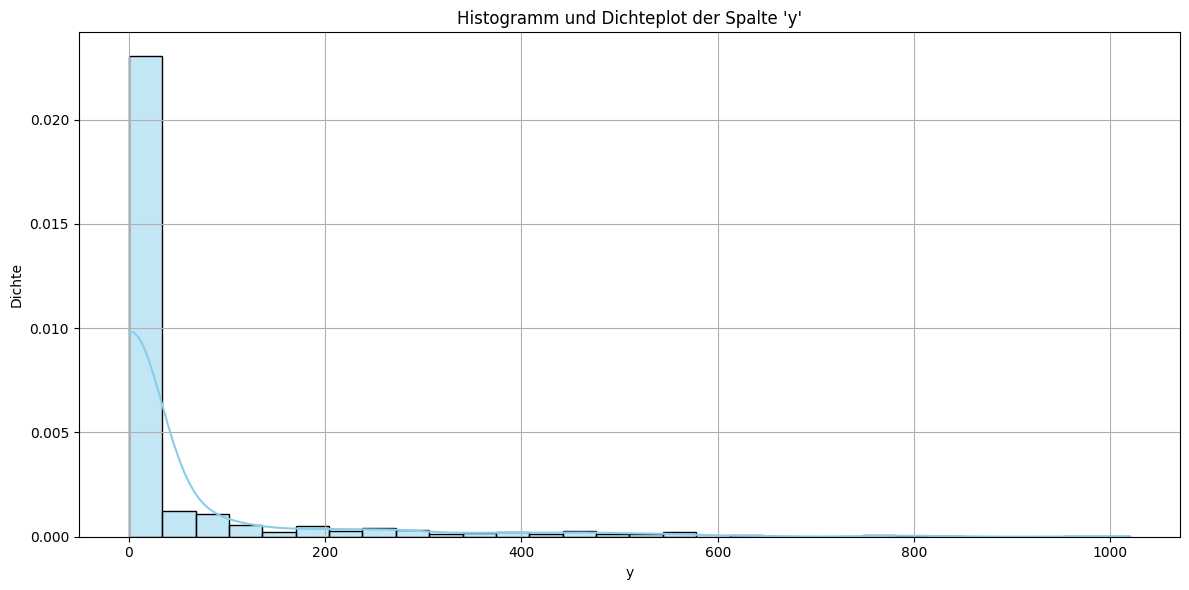

<Figure size 640x480 with 0 Axes>

In [22]:
# 📉 Histogramm mit Dichteplot

# Plot erstellen
plt.figure(figsize=(12, 6))
sns.histplot(series, bins=bins, kde=True, color='skyblue', stat="density")
plt.title(f"Histogramm und Dichteplot der Spalte '{spalte}'")
plt.xlabel(spalte)
plt.ylabel("Dichte")
plt.grid(True)
plt.tight_layout()

# Grafik anzeigen und speichern
plt.show()
path = os.path.join(fig_dir, f"verteilung_{spalte}.png")
plt.savefig(path, dpi=300)

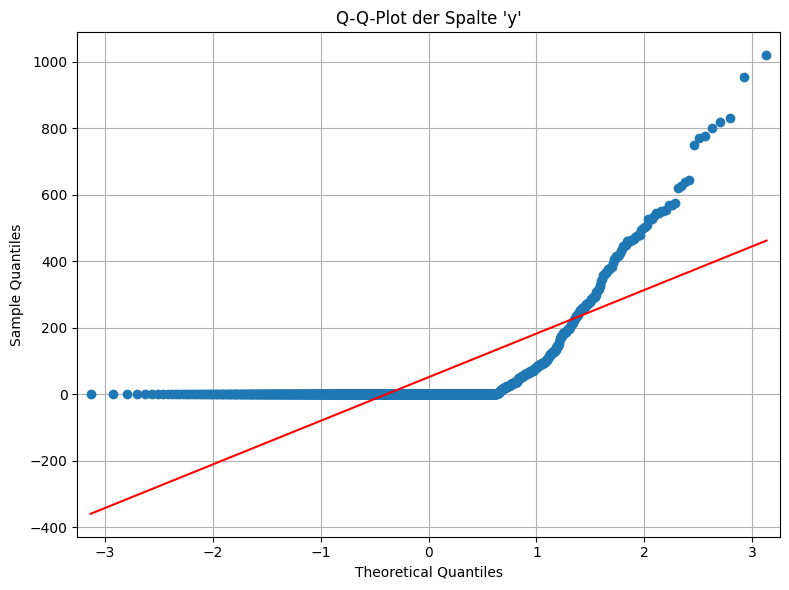

<Figure size 640x480 with 0 Axes>

In [23]:
# 📐 Q-Q-Plot

plt.figure(figsize=(8, 6))
qqplot(series, line='s', ax=plt.gca())
plt.title(f"Q-Q-Plot der Spalte '{spalte}'")
plt.grid(True)
plt.tight_layout()

# Grafik anzeigen und speichern
plt.show()
path = os.path.join(fig_dir, f"qqplot_{spalte}.png")
plt.savefig(path, dpi=300)

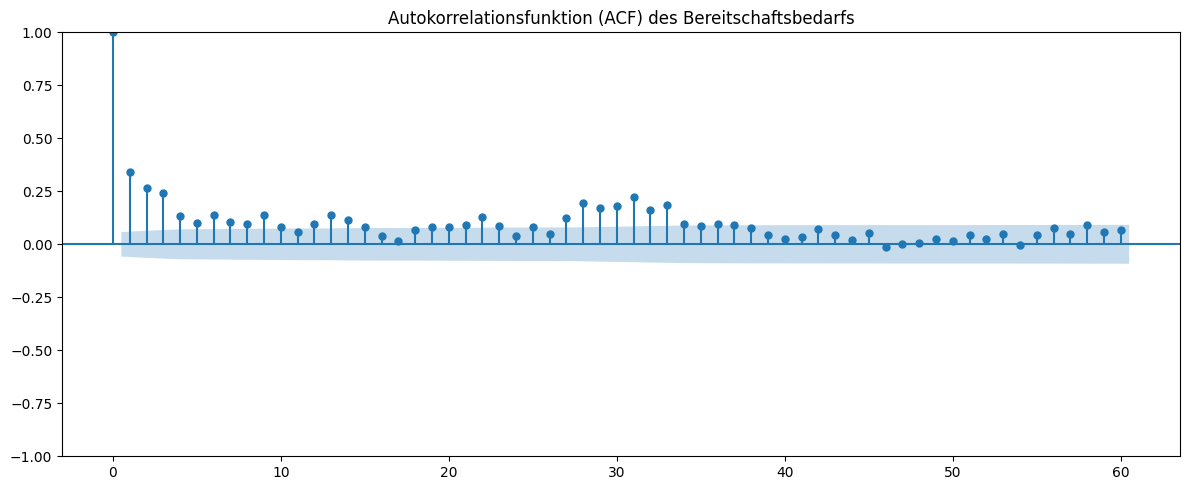

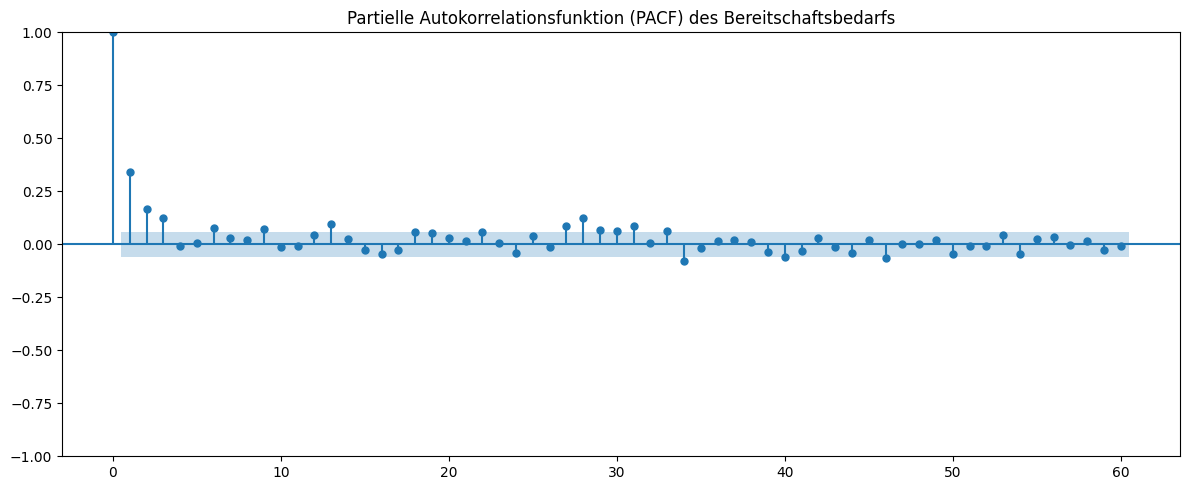

In [24]:
# 🔁 Autokorrelationsanalyse des Bereitschaftsbedarfs (y)

from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np

# Serie bereinigen
y_series = df["y"].dropna()

# ACF & PACF berechnen
acf_values = acf(y_series, nlags=60)
pacf_values = pacf(y_series, nlags=60)

# ACF-Plot
fig, ax = plt.subplots(figsize=(12, 5))
plot_acf(y_series, lags=60, ax=ax)
ax.set_title("Autokorrelationsfunktion (ACF) des Bereitschaftsbedarfs")
plt.tight_layout()
acf_path = os.path.join(fig_dir, "acf_bereitschaftsbedarf.png")
plt.savefig(acf_path, dpi=300)
plt.show()

# PACF-Plot
fig, ax = plt.subplots(figsize=(12, 5))
plot_pacf(y_series, lags=60, ax=ax)
ax.set_title("Partielle Autokorrelationsfunktion (PACF) des Bereitschaftsbedarfs")
plt.tight_layout()
path = os.path.join(fig_dir, "pacf_bereitschaftsbedarf.png")
plt.savefig(path, dpi=300)
plt.show()

In [25]:
# Signifikante Lags identifizieren
significance_threshold = 0.2
acf_significant = np.where(np.abs(acf_values) > significance_threshold)[0]
pacf_significant = np.where(np.abs(pacf_values) > significance_threshold)[0]

# Textuelle Zusammenfassung
print("📋 Interpretation der Autokorrelationsanalyse:\n")
print(f"- ACF: Signifikante Korrelationen bei Lags: {', '.join(map(str, acf_significant)) if len(acf_significant) > 0 else 'keine'}.")
print(f"- PACF: Signifikante direkte Einflüsse bei Lags: {', '.join(map(str, pacf_significant)) if len(pacf_significant) > 0 else 'keine'}.\n")

📋 Interpretation der Autokorrelationsanalyse:

- ACF: Signifikante Korrelationen bei Lags: 0, 1, 2, 3, 31.
- PACF: Signifikante direkte Einflüsse bei Lags: 0, 1.



In [26]:
# 📅 Saisonale Merkmale & aggregierte Mittelwerte vorbereiten

# Zusätzliche Zeitspalte: Jahreszeit (0=Winter, 1=Frühling, ...)
df['season'] = df.index.month % 12 // 3

# Wochentag, Monat, Quartal
weekly_mean = df.groupby(df.index.weekday)['y'].mean()
monthly_mean = df.groupby(df.index.month)['y'].mean()
quarterly_mean = df.groupby(df.index.quarter)['y'].mean()
seasonal_mean = df.groupby(df['season'])['y'].mean()

# Beschriftungen
week_labels = ["Montag", "Dienstag", "Mittwoch", "Donnerstag", "Freitag", "Samstag", "Sonntag"]
month_labels = ["Jan", "Feb", "Mär", "Apr", "Mai", "Jun", "Jul", "Aug", "Sep", "Okt", "Nov", "Dez"]
quarter_labels = ["Q1", "Q2", "Q3", "Q4"]
season_labels = ["Winter", "Frühling", "Sommer", "Herbst"]

# Spitzenwerte
weekly_peak = (week_labels[np.argmax(weekly_mean)], np.max(weekly_mean))
weekly_low = (week_labels[np.argmin(weekly_mean)], np.min(weekly_mean))
monthly_peak = (month_labels[np.argmax(monthly_mean)], np.max(monthly_mean))
monthly_low = (month_labels[np.argmin(monthly_mean)], np.min(monthly_mean))
quarterly_peak = (quarter_labels[np.argmax(quarterly_mean)], np.max(quarterly_mean))
quarterly_low = (quarter_labels[np.argmin(quarterly_mean)], np.min(quarterly_mean))
seasonal_peak = (season_labels[np.argmax(seasonal_mean)], np.max(seasonal_mean))
seasonal_low = (season_labels[np.argmin(seasonal_mean)], np.min(seasonal_mean))

# Ausreißeranalyse (IQR) nach Wochentag & Monat
weekly_outliers = df.groupby(df.index.weekday)['y'].apply(
    lambda x: ((x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) |
               (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))).sum()
)
monthly_outliers = df.groupby(df.index.month)['y'].apply(
    lambda x: ((x < (x.quantile(0.25) - 1.5 * (x.quantile(0.75) - x.quantile(0.25)))) |
               (x > (x.quantile(0.75) + 1.5 * (x.quantile(0.75) - x.quantile(0.25))))).sum()
)

# Textuelle Zusammenfassung
print(f"""
📋 Saisonale Analyse des Bereitschaftsbedarfs:

Wöchentlich:
- Höchster Bedarf: {weekly_peak[0]} ({weekly_peak[1]:.2f})
- Niedrigster Bedarf: {weekly_low[0]} ({weekly_low[1]:.2f})
- Meiste Ausreißer: {week_labels[np.argmax(weekly_outliers)]}

Monatlich:
- Höchster Bedarf: {monthly_peak[0]} ({monthly_peak[1]:.2f})
- Niedrigster Bedarf: {monthly_low[0]} ({monthly_low[1]:.2f})
- Meiste Ausreißer: {month_labels[np.argmax(monthly_outliers)]}

Saisonal:
- Höchster Bedarf: {seasonal_peak[0]} ({seasonal_peak[1]:.2f})
- Niedrigster Bedarf: {seasonal_low[0]} ({seasonal_low[1]:.2f})

Quartalsweise:
- Höchster Bedarf: {quarterly_peak[0]} ({quarterly_peak[1]:.2f})
- Niedrigster Bedarf: {quarterly_low[0]} ({quarterly_low[1]:.2f})
""")


📋 Saisonale Analyse des Bereitschaftsbedarfs:

Wöchentlich:
- Höchster Bedarf: Montag (77.85)
- Niedrigster Bedarf: Sonntag (13.85)
- Meiste Ausreißer: Freitag

Monatlich:
- Höchster Bedarf: Jun (99.11)
- Niedrigster Bedarf: Jan (2.10)
- Meiste Ausreißer: Mär

Saisonal:
- Höchster Bedarf: Sommer (81.84)
- Niedrigster Bedarf: Winter (5.40)

Quartalsweise:
- Höchster Bedarf: Q2 (89.43)
- Niedrigster Bedarf: Q4 (16.93)



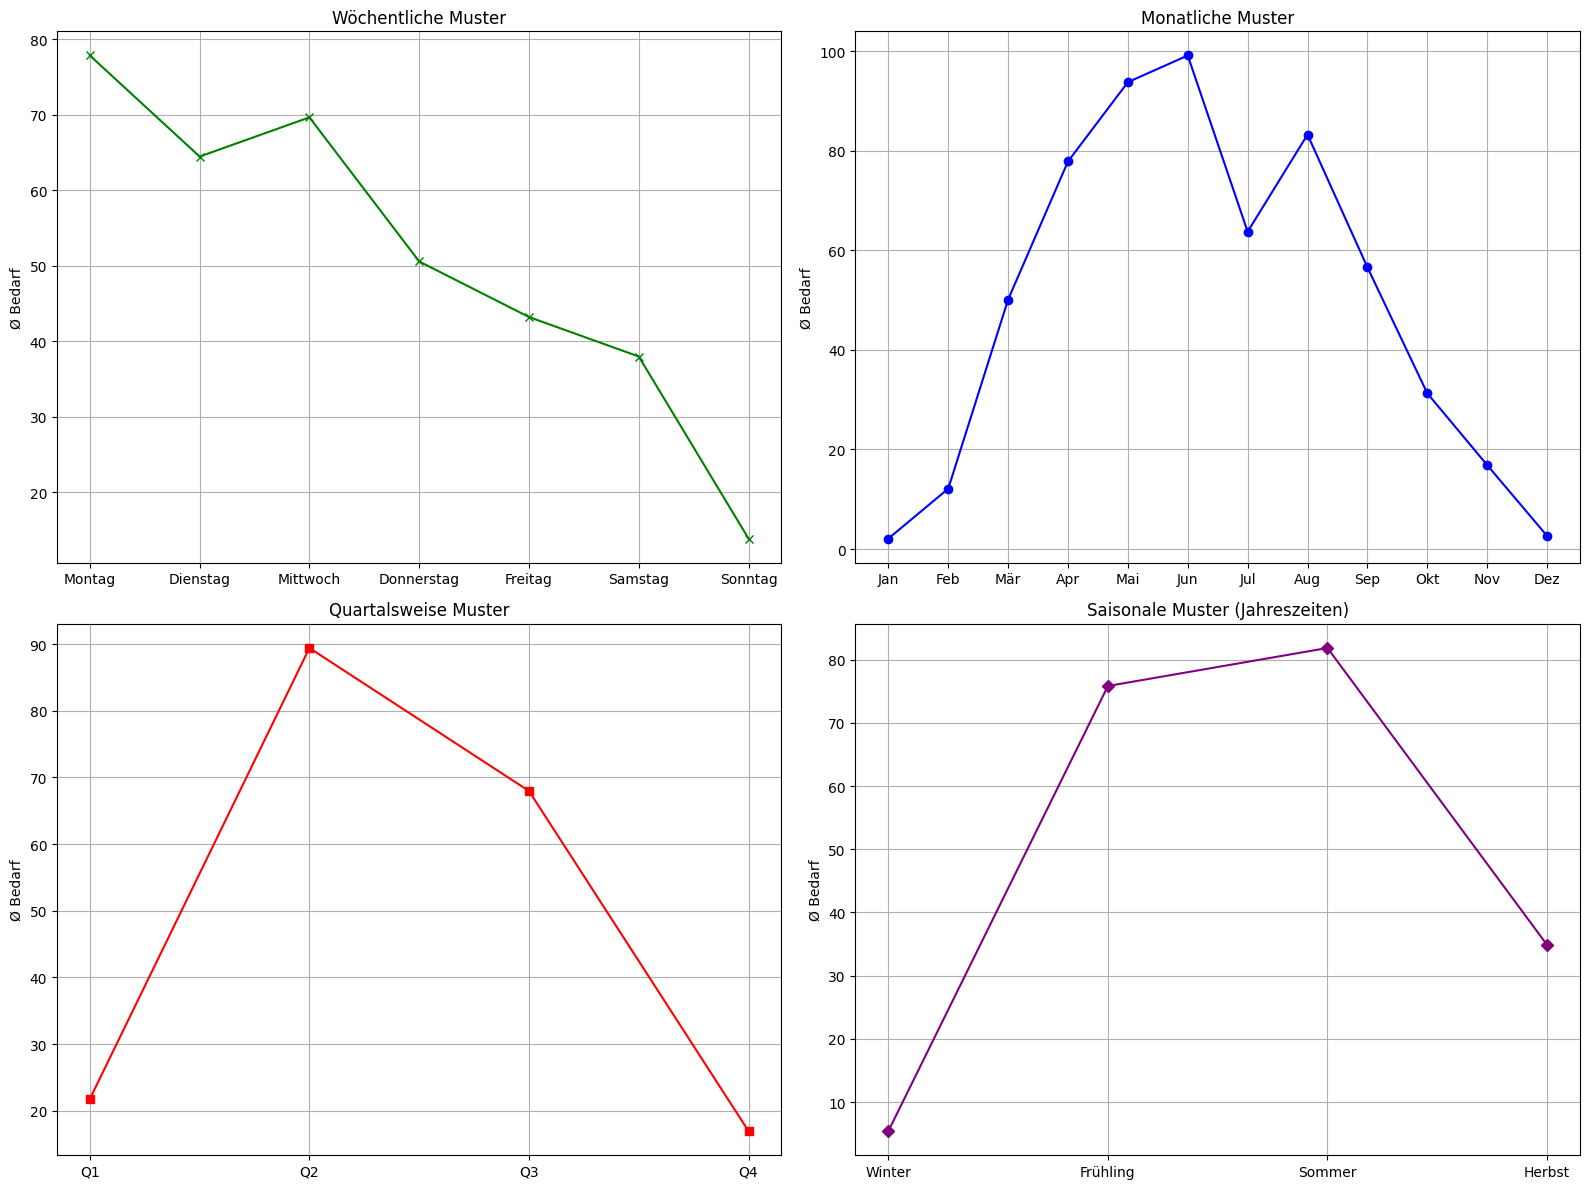

In [28]:
# 📈 Saisonale Muster – Liniendiagramme

fig, axs = plt.subplots(2, 2, figsize=(16, 12))

axs[0, 0].plot(range(1, 8), weekly_mean, marker='x', color='green', label="Wöchentliche Muster")
axs[0, 0].set_xticks(range(1, 8))
axs[0, 0].set_xticklabels(week_labels)
axs[0, 0].set_title("Wöchentliche Muster")
axs[0, 0].set_ylabel("Ø Bedarf")
axs[0, 0].grid(True)

axs[0, 1].plot(range(1, 13), monthly_mean, marker='o', color='blue', label="Monatliche Muster")
axs[0, 1].set_xticks(range(1, 13))
axs[0, 1].set_xticklabels(month_labels)
axs[0, 1].set_title("Monatliche Muster")
axs[0, 1].set_ylabel("Ø Bedarf")
axs[0, 1].grid(True)

axs[1, 0].plot(range(1, 5), quarterly_mean, marker='s', color='red', label="Quartale")
axs[1, 0].set_xticks(range(1, 5))
axs[1, 0].set_xticklabels(quarter_labels)
axs[1, 0].set_title("Quartalsweise Muster")
axs[1, 0].set_ylabel("Ø Bedarf")
axs[1, 0].grid(True)

axs[1, 1].plot(range(1, 5), seasonal_mean, marker='D', color='purple', label="Saisonal")
axs[1, 1].set_xticks(range(1, 5))
axs[1, 1].set_xticklabels(season_labels)
axs[1, 1].set_title("Saisonale Muster (Jahreszeiten)")
axs[1, 1].set_ylabel("Ø Bedarf")
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()

# Speichern
path = os.path.join(fig_dir, "saisonale_muster_liniendiagramme.png")
fig.savefig(path, dpi=300)

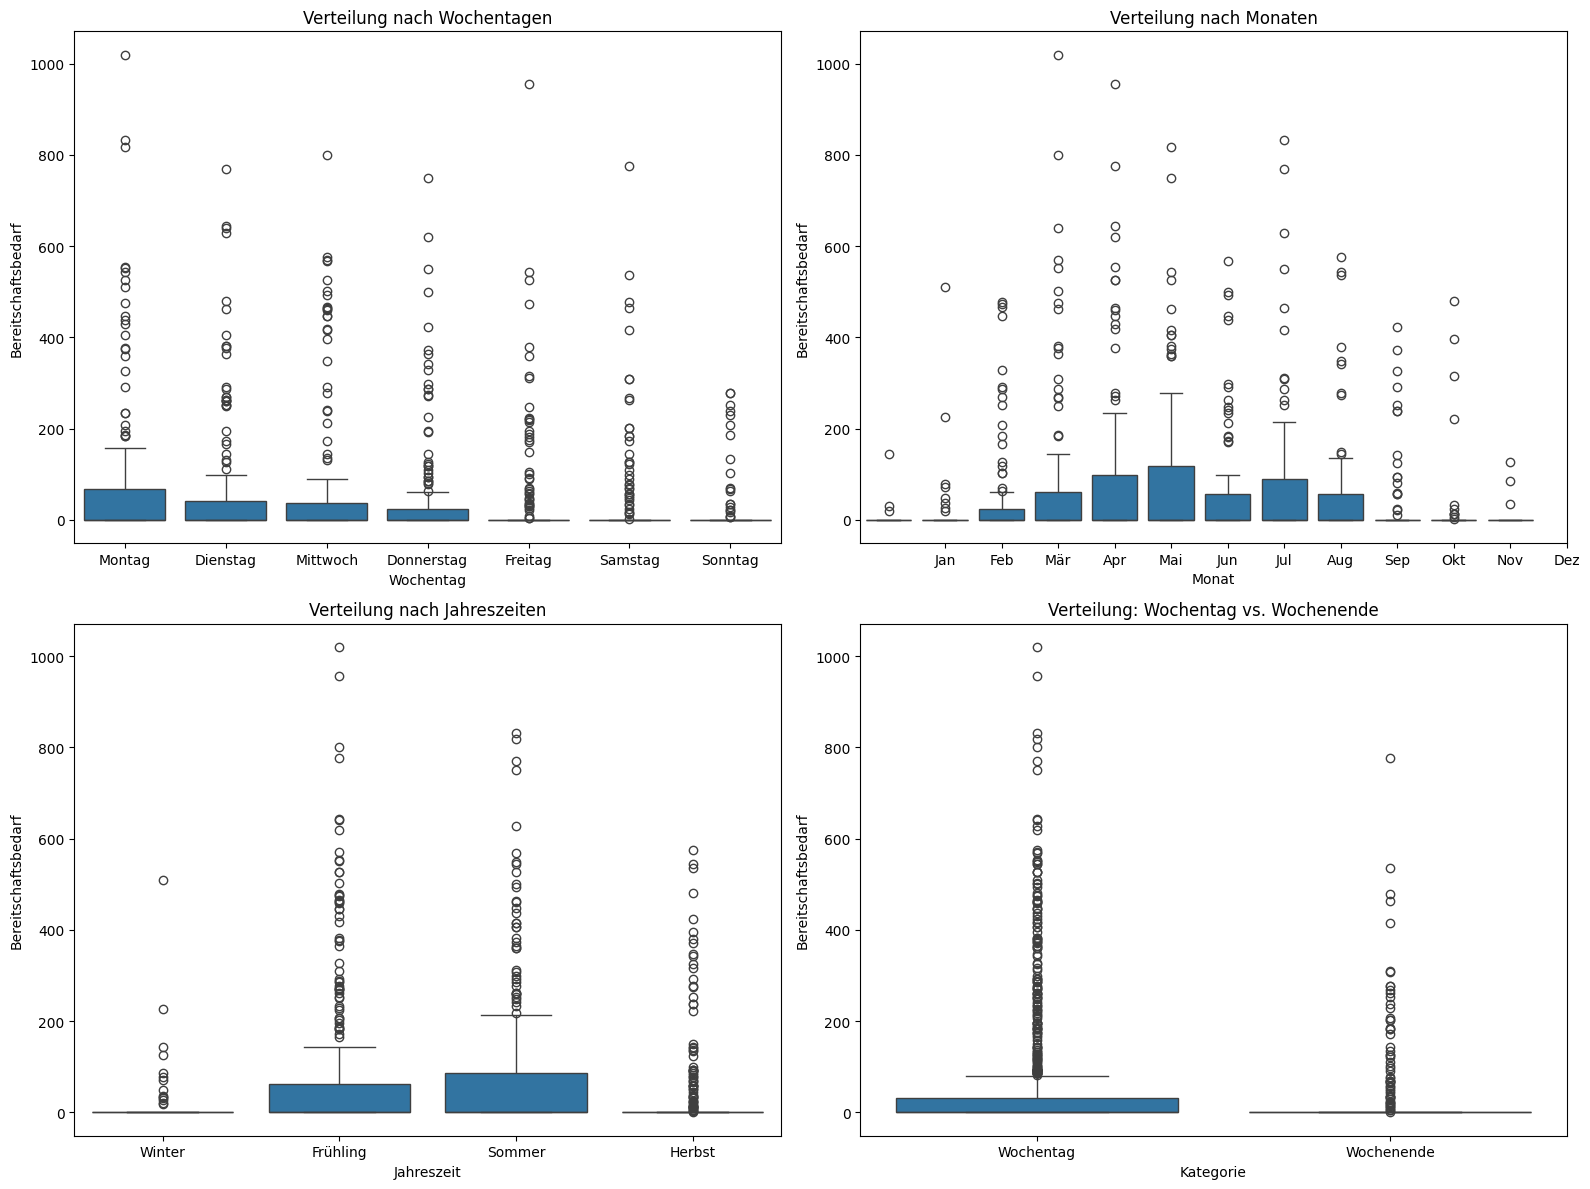

In [29]:
# 📦 Boxplots zur saisonalen Verteilung des Bereitschaftsbedarfs

# 'weekend'-Spalte sicherstellen
df["weekend"] = df.index.weekday >= 5

fig2, axs2 = plt.subplots(2, 2, figsize=(16, 12))

# Boxplot: Verteilung nach Wochentagen
sns.boxplot(x=df.index.weekday, y=df["y"], ax=axs2[0, 0])
axs2[0, 0].set_xticks(range(7))
axs2[0, 0].set_xticklabels(week_labels)
axs2[0, 0].set_title("Verteilung nach Wochentagen")
axs2[0, 0].set_xlabel("Wochentag")
axs2[0, 0].set_ylabel("Bereitschaftsbedarf")

# Boxplot: Verteilung nach Monaten
sns.boxplot(x=df.index.month, y=df["y"], ax=axs2[0, 1])
axs2[0, 1].set_xticks(range(1, 13))
axs2[0, 1].set_xticklabels(month_labels)
axs2[0, 1].set_title("Verteilung nach Monaten")
axs2[0, 1].set_xlabel("Monat")
axs2[0, 1].set_ylabel("Bereitschaftsbedarf")

# Boxplot: Verteilung nach Jahreszeiten
sns.boxplot(x=df["season"], y=df["y"], ax=axs2[1, 0])
axs2[1, 0].set_xticks(range(4))
axs2[1, 0].set_xticklabels(season_labels)
axs2[1, 0].set_title("Verteilung nach Jahreszeiten")
axs2[1, 0].set_xlabel("Jahreszeit")
axs2[1, 0].set_ylabel("Bereitschaftsbedarf")

# Boxplot: Wochentag vs. Wochenende
sns.boxplot(x=df["weekend"], y=df["y"], ax=axs2[1, 1])
axs2[1, 1].set_xticks([0, 1])
axs2[1, 1].set_xticklabels(["Wochentag", "Wochenende"])
axs2[1, 1].set_title("Verteilung: Wochentag vs. Wochenende")
axs2[1, 1].set_xlabel("Kategorie")
axs2[1, 1].set_ylabel("Bereitschaftsbedarf")

plt.tight_layout()
plt.show()

# Speichern
path = os.path.join(fig_dir, "saisonale_muster_boxplots.png")
fig2.savefig(path, dpi=300)

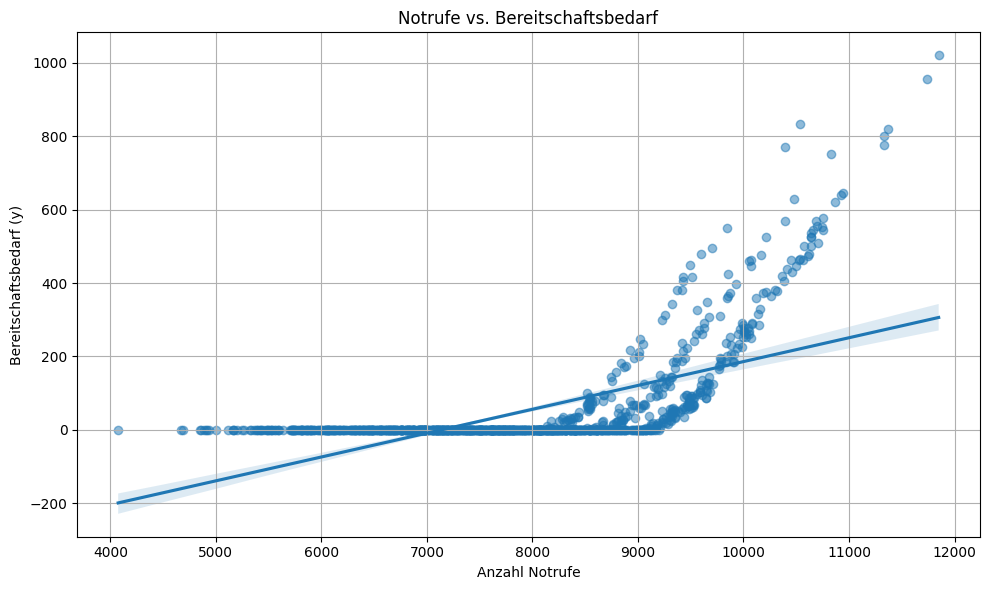

In [30]:
from scipy.stats import pearsonr, spearmanr, kendalltau

# 📊 Scatterplot: Notrufe vs. Bereitschaftsbedarf
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=df["calls"], y=df["y"], scatter_kws={'alpha': 0.5}, ax=ax)
ax.set_title("Notrufe vs. Bereitschaftsbedarf")
ax.set_xlabel("Anzahl Notrufe")
ax.set_ylabel("Bereitschaftsbedarf (y)")
ax.grid(True)
plt.tight_layout()
plt.show()

scatter_path_1 = os.path.join(fig_dir, "scatter_calls_vs_y.png")
fig.savefig(scatter_path_1, dpi=300)

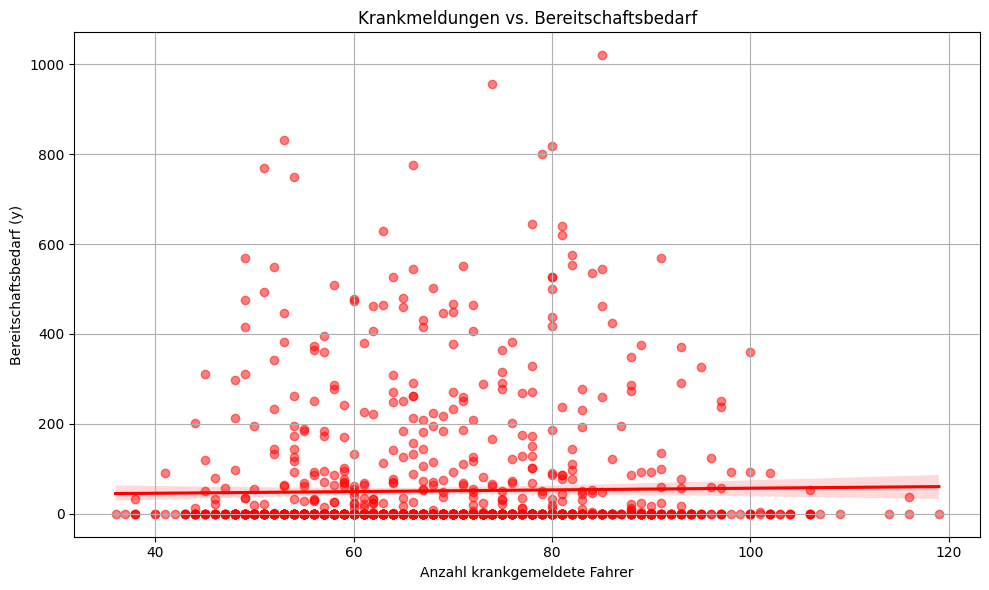

In [31]:
# 📊 Scatterplot: Krankmeldungen vs. Bereitschaftsbedarf
fig, ax = plt.subplots(figsize=(10, 6))
sns.regplot(x=df["n_sick"], y=df["y"], scatter_kws={'alpha': 0.5}, color='red', ax=ax)
ax.set_title("Krankmeldungen vs. Bereitschaftsbedarf")
ax.set_xlabel("Anzahl krankgemeldete Fahrer")
ax.set_ylabel("Bereitschaftsbedarf (y)")
ax.grid(True)
plt.tight_layout()
plt.show()

scatter_path_2 = os.path.join(fig_dir, "scatter_sick_vs_y.png")
fig.savefig(scatter_path_2, dpi=300)

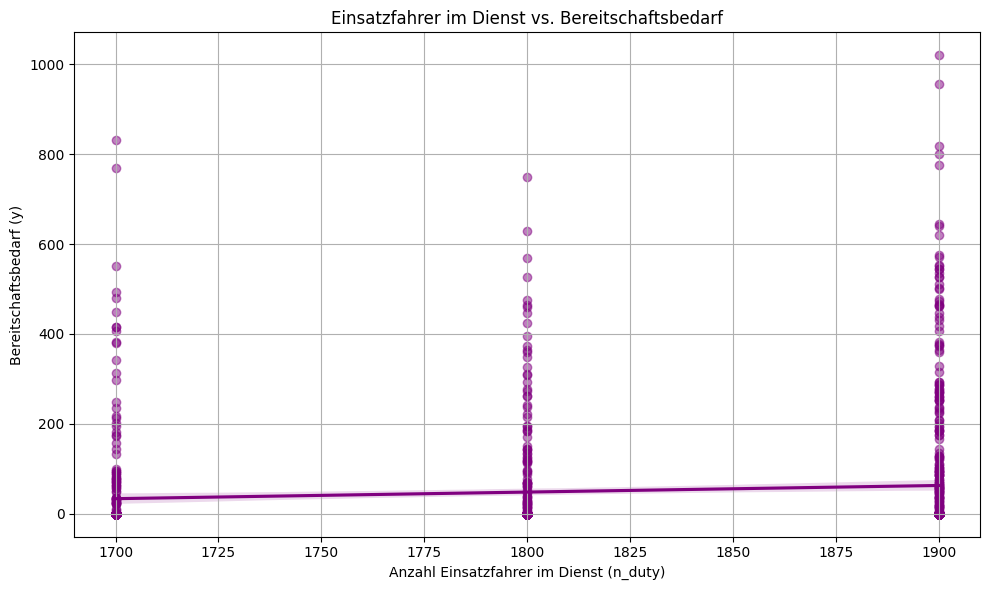

In [32]:
# 📊 Scatterplot: n_duty vs. Bereitschaftsbedarf (nur falls nicht konstant)
if df["n_duty"].nunique() == 1:
    print("ℹ️ Die Variable 'n_duty' ist konstant. Scatterplot wird übersprungen.")
else:
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.regplot(x=df["n_duty"], y=df["y"], scatter_kws={'alpha': 0.5}, color='purple', ax=ax)
    ax.set_title("Einsatzfahrer im Dienst vs. Bereitschaftsbedarf")
    ax.set_xlabel("Anzahl Einsatzfahrer im Dienst (n_duty)")
    ax.set_ylabel("Bereitschaftsbedarf (y)")
    ax.grid(True)
    plt.tight_layout()
    plt.show()

    scatter_path_3 = os.path.join(fig_dir, "scatter_duty_vs_y.png")
    fig.savefig(scatter_path_3, dpi=300)

In [33]:
# 📈 Korrelationen berechnen

# Notrufe vs. y
pearson_corr_calls, pearson_p_calls = pearsonr(df["calls"], df["y"])
spearman_corr_calls, spearman_p_calls = spearmanr(df["calls"], df["y"])
kendall_corr_calls, kendall_p_calls = kendalltau(df["calls"], df["y"])

# Krankmeldungen vs. y
pearson_corr_sick, pearson_p_sick = pearsonr(df["n_sick"], df["y"])
spearman_corr_sick, spearman_p_sick = spearmanr(df["n_sick"], df["y"])
kendall_corr_sick, kendall_p_sick = kendalltau(df["n_sick"], df["y"])

# n_duty vs. y (nur wenn nicht konstant)
if df["n_duty"].nunique() == 1:
    pearson_corr_duty = spearman_corr_duty = kendall_corr_duty = np.nan
    pearson_p_duty = spearman_p_duty = kendall_p_duty = np.nan
    print("ℹ️ 'n_duty' ist konstant. Korrelationen nicht berechenbar.")
else:
    pearson_corr_duty, pearson_p_duty = pearsonr(df["n_duty"], df["y"])
    spearman_corr_duty, spearman_p_duty = spearmanr(df["n_duty"], df["y"])
    kendall_corr_duty, kendall_p_duty = kendalltau(df["n_duty"], df["y"])

# Ergebnisse ausgeben
print("📋 Korrelationskoeffizienten (y vs. externe Variablen):\n")

print("→ Notrufe:")
print(f"  Pearson : {pearson_corr_calls:.2f} (p={pearson_p_calls:.3f})")
print(f"  Spearman: {spearman_corr_calls:.2f} (p={spearman_p_calls:.3f})")
print(f"  Kendall : {kendall_corr_calls:.2f} (p={kendall_p_calls:.3f})\n")

print("→ Krankmeldungen:")
print(f"  Pearson : {pearson_corr_sick:.2f} (p={pearson_p_sick:.3f})")
print(f"  Spearman: {spearman_corr_sick:.2f} (p={spearman_p_sick:.3f})")
print(f"  Kendall : {kendall_corr_sick:.2f} (p={kendall_p_sick:.3f})\n")

if not np.isnan(pearson_corr_duty):
    print("→ Einsatzfahrer im Dienst:")
    print(f"  Pearson : {pearson_corr_duty:.2f} (p={pearson_p_duty:.3f})")
    print(f"  Spearman: {spearman_corr_duty:.2f} (p={spearman_p_duty:.3f})")
    print(f"  Kendall : {kendall_corr_duty:.2f} (p={kendall_p_duty:.3f})\n")

📋 Korrelationskoeffizienten (y vs. externe Variablen):

→ Notrufe:
  Pearson : 0.64 (p=0.000)
  Spearman: 0.74 (p=0.000)
  Kendall : 0.61 (p=0.000)

→ Krankmeldungen:
  Pearson : 0.02 (p=0.490)
  Spearman: 0.04 (p=0.187)
  Kendall : 0.03 (p=0.193)

→ Einsatzfahrer im Dienst:
  Pearson : 0.09 (p=0.002)
  Spearman: 0.08 (p=0.009)
  Kendall : 0.07 (p=0.009)



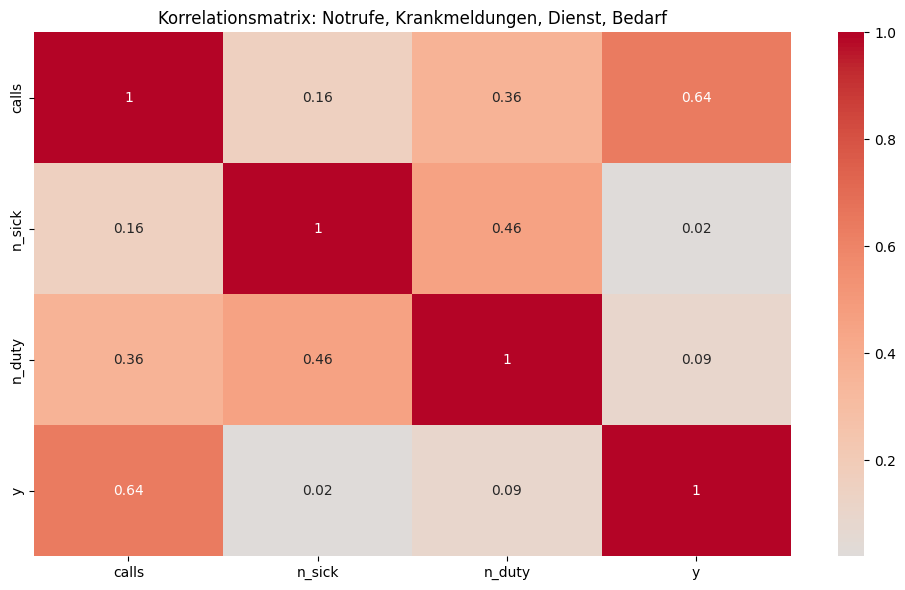

<Figure size 640x480 with 0 Axes>

In [34]:
# 🔥 Korrelationsmatrix-Heatmap

plt.figure(figsize=(10, 6))
corr_matrix = df[["calls", "n_sick", "n_duty", "y"]].corr()
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Korrelationsmatrix: Notrufe, Krankmeldungen, Dienst, Bedarf")
plt.tight_layout()
plt.show()

heatmap_path = os.path.join(fig_dir, "korrelationsmatrix_heatmap.png")
plt.savefig(heatmap_path, dpi=300)

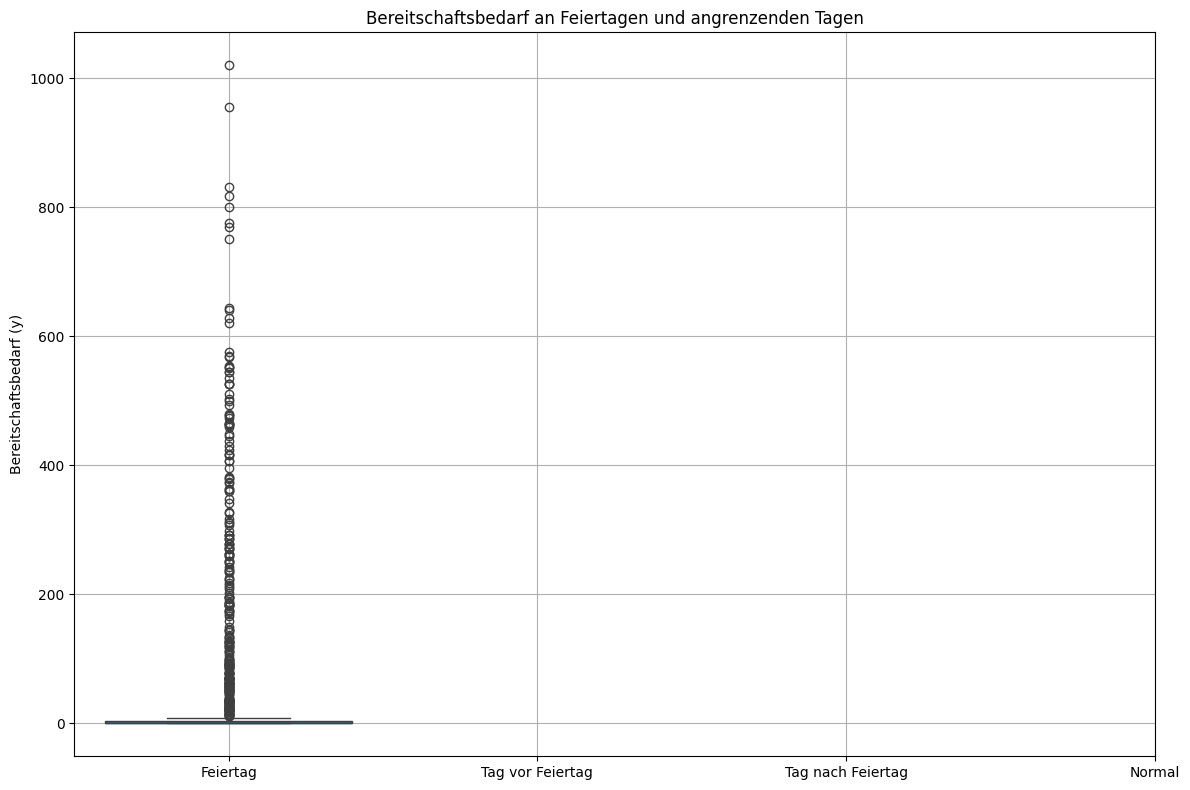

<Figure size 640x480 with 0 Axes>

In [35]:
# 📅 Feiertagsanalyse: Vergleich von Feiertagen, Vortagen, Folgetagen und normalen Tagen

from dateutil.easter import easter
from scipy.stats import ttest_ind, mannwhitneyu

# Hilfsfunktion zur Erstellung deutscher Feiertage
def get_german_holidays(start_year, end_year):
    holiday_dict = {}
    for year in range(start_year, end_year + 1):
        easter_sunday = easter(year)
        holiday_dict.update({
            "Neujahr": f"{year}-01-01",
            "Heilige Drei Könige": f"{year}-01-06",
            "Valentinstag": f"{year}-02-14",
            "Rosenmontag": (easter_sunday - pd.Timedelta(days=48)).strftime("%Y-%m-%d"),
            "Internationaler Frauentag": f"{year}-03-08",
            "Gründonnerstag": (easter_sunday - pd.Timedelta(days=3)).strftime("%Y-%m-%d"),
            "Karfreitag": (easter_sunday - pd.Timedelta(days=2)).strftime("%Y-%m-%d"),
            "Ostersonntag": easter_sunday.strftime("%Y-%m-%d"),
            "Ostermontag": (easter_sunday + pd.Timedelta(days=1)).strftime("%Y-%m-%d"),
            "Tag der Arbeit": f"{year}-05-01",
            "Christi Himmelfahrt": (easter_sunday + pd.Timedelta(days=39)).strftime("%Y-%m-%d"),
            "Pfingstsonntag": (easter_sunday + pd.Timedelta(days=49)).strftime("%Y-%m-%d"),
            "Pfingstmontag": (easter_sunday + pd.Timedelta(days=50)).strftime("%Y-%m-%d"),
            "Fronleichnam": (easter_sunday + pd.Timedelta(days=60)).strftime("%Y-%m-%d"),
            "Mariä Himmelfahrt": f"{year}-08-15",
            "Tag der Deutschen Einheit": f"{year}-10-03",
            "Reformationstag": f"{year}-10-31",
            "Allerheiligen": f"{year}-11-01",
            "Volkstrauertag": (easter_sunday + pd.Timedelta(days=35)).strftime("%Y-%m-%d"),
            "Buß- und Bettag": (easter_sunday + pd.Timedelta(days=42)).strftime("%Y-%m-%d"),
            "Heiligabend": f"{year}-12-24",
            "Erster Weihnachtsfeiertag": f"{year}-12-25",
            "Zweiter Weihnachtsfeiertag": f"{year}-12-26",
            "Silvester": f"{year}-12-31"
        })
    return holiday_dict

# Feiertage ermitteln
start_year, end_year = df.index.min().year, df.index.max().year
holiday_dict = get_german_holidays(start_year, end_year)
holiday_df = pd.DataFrame(holiday_dict.items(), columns=["Feiertag", "Datum"])
holiday_df["Datum"] = pd.to_datetime(holiday_df["Datum"], errors='coerce')
holiday_df.set_index("Datum", inplace=True)

# Neue Spalten für Feiertage
df["holiday"] = df.index.isin(holiday_df.index)
df["pre_holiday"] = df.index.map(lambda d: (d + pd.Timedelta(days=1)) in holiday_df.index)
df["post_holiday"] = df.index.map(lambda d: (d - pd.Timedelta(days=1)) in holiday_df.index)
df["normal_day"] = ~(df["holiday"] | df["pre_holiday"] | df["post_holiday"])

# Gruppen definieren
y_holiday = df[df["holiday"]]["y"]
y_pre = df[df["pre_holiday"]]["y"]
y_post = df[df["post_holiday"]]["y"]
y_normal = df[df["normal_day"]]["y"]

# Boxplot
plt.figure(figsize=(12, 8))
data_to_plot = [y_holiday, y_pre, y_post, y_normal]
labels = ["Feiertag", "Tag vor Feiertag", "Tag nach Feiertag", "Normal"]
sns.boxplot(data=data_to_plot)
plt.xticks(ticks=range(4), labels=labels)
plt.title("Bereitschaftsbedarf an Feiertagen und angrenzenden Tagen")
plt.ylabel("Bereitschaftsbedarf (y)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Speichern
plot_path = os.path.join(fig_dir, "feiertagsanalyse_boxplot.png")
plt.savefig(plot_path, dpi=300)

In [36]:
# 📊 Statistische Tests zwischen Gruppen und normalen Tagen

tests = {}
for label, group in zip(["Feiertag", "Tag vor Feiertag", "Tag nach Feiertag"], [y_holiday, y_pre, y_post]):
    if len(group) > 0 and len(y_normal) > 0:
        t_stat, t_p = ttest_ind(group, y_normal, nan_policy='omit')
        mw_stat, mw_p = mannwhitneyu(group, y_normal)
        tests[label] = {
            "t-test_p": t_p,
            "mannwhitneyu_p": mw_p,
            "mean_group": group.mean(),
            "mean_normal": y_normal.mean()
        }

# Ergebnisse anzeigen
print("📋 Feiertagsanalyse – Mittelwerte & p-Werte im Vergleich zu normalen Tagen:\n")
for label, res in tests.items():
    print(f"{label}:")
    print(f"  Ø Bedarf: {res['mean_group']:.2f} vs. Normal: {res['mean_normal']:.2f}")
    print(f"  t-Test p-Wert: {res['t-test_p']:.3f}")
    print(f"  Mann-Whitney U-Test p-Wert: {res['mannwhitneyu_p']:.3f}\n")

📋 Feiertagsanalyse – Mittelwerte & p-Werte im Vergleich zu normalen Tagen:

Feiertag:
  Ø Bedarf: 101.45 vs. Normal: 49.69
  t-Test p-Wert: 0.193
  Mann-Whitney U-Test p-Wert: 0.024

Tag vor Feiertag:
  Ø Bedarf: 126.73 vs. Normal: 49.69
  t-Test p-Wert: 0.052
  Mann-Whitney U-Test p-Wert: 0.002

Tag nach Feiertag:
  Ø Bedarf: 86.45 vs. Normal: 49.69
  t-Test p-Wert: 0.354
  Mann-Whitney U-Test p-Wert: 0.034



In [37]:
# 📊 Erweiterte Feiertagsanalyse einzelner Feiertage

# Feiertage mappen
holidays_df = holiday_df.copy()
holidays_df["Feiertag"] = holidays_df["Feiertag"].astype(str)
holiday_mapping = holidays_df["Feiertag"].to_dict()
df["holiday_name"] = df.index.map(lambda d: holiday_mapping.get(d, np.nan))

# Spalten absichern
df["holiday"] = df.index.isin(holidays_df.index)
df["pre_holiday"] = df.index.map(lambda d: (d + pd.Timedelta(days=1)) in holidays_df.index)
df["post_holiday"] = df.index.map(lambda d: (d - pd.Timedelta(days=1)) in holidays_df.index)
df["normal_day"] = ~(df["holiday"] | df["pre_holiday"] | df["post_holiday"])
normal_y = df[df["normal_day"]]["y"]

# Einzeln analysierte Feiertage
results = []
unique_holidays = df["holiday_name"].dropna().unique()

for holiday in unique_holidays:
    dates = df.index[df["holiday_name"] == holiday]
    combined = set()
    for d in dates:
        if d - pd.Timedelta(days=1) in df.index:
            combined.add(d - pd.Timedelta(days=1))
        combined.add(d)
        if d + pd.Timedelta(days=1) in df.index:
            combined.add(d + pd.Timedelta(days=1))
    y_group = df.loc[df.index.isin(combined)]["y"]
    if len(y_group) < 3 or len(normal_y) < 3:
        continue
    t_stat, t_p = ttest_ind(y_group, normal_y, nan_policy='omit')
    mw_stat, mw_p = mannwhitneyu(y_group, normal_y)
    results.append({
        "Feiertag": holiday,
        "n_Holiday_Group": len(y_group),
        "n_Normal": len(normal_y),
        "mean_Holiday_Group": y_group.mean(),
        "mean_Normal": normal_y.mean(),
        "t-test_p": t_p,
        "mannwhitneyu_p": mw_p
    })

# Ausgabe
results_df = pd.DataFrame(results)
print("📋 Einzelergebnisse: Durchschnittswerte & p-Werte pro Feiertag (inkl. angrenzende Tage)\n")
display(results_df)

📋 Einzelergebnisse: Durchschnittswerte & p-Werte pro Feiertag (inkl. angrenzende Tage)



,Feiertag,n_Holiday_Group,n_Normal,mean_Holiday_Group,mean_Normal,t-test_p,mannwhitneyu_p
0,Neujahr,3,1124,48.000000,49.692171,0.982162,0.730188
1,Heilige Drei Könige,3,1124,0.000000,49.692171,0.511344,0.317309
2,Valentinstag,3,1124,0.000000,49.692171,0.511344,0.317309
3,Rosenmontag,3,1124,161.666667,49.692171,0.139355,0.003930
4,Internationaler Frauentag,3,1124,34.000000,49.692171,0.835719,0.770562
5,Gründonnerstag,3,1124,43.333333,49.692171,0.933025,0.172231
6,Karfreitag,3,1124,132.666667,49.692171,0.273244,0.004974
7,Ostersonntag,3,1124,123.333333,49.692171,0.330937,0.082138
8,Ostermontag,3,1124,159.333333,49.692171,0.148267,0.071366
9,Tag der Arbeit,3,1124,307.333333,49.692171,0.000698,0.000870
